# <div style="background-color: #ff758f; color: white; padding: 20px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 35px; margin: 5px; font-weight:bold;">🫁 Pneumonia Detection</div>


<center>
<img src="https://img.freepik.com/free-vector/pneumonia-realistic-infographic_1284-59342.jpg" alt="Student" width="auto" height="auto" style="border-radius:25px">
</center>

<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">Pneumonia is a lung infection caused by various microorganisms, including bacteria, viruses, and fungi. It occurs when these pathogens invade the lungs, leading to inflammation and fluid buildup in the air sacs (alveoli). This can make breathing difficult and impair oxygen delivery to the body. Pneumonia is a significant global health concern, affecting people of all ages, particularly infants, young children, the elderly, and those with weakened immune systems. Its impact is felt worldwide, with millions of cases and deaths occurring each year.
</div>


# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Importing Dependencies</div>

In [1]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

warnings.filterwarnings('ignore')

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Dataset Description</div>
 
 
<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">
<p>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
<p>
</div>

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Loading Dataset</div>

In [2]:
# Labels for image categories
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def loading_training_data(data_dir):
    data = []
    labels_list = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
            labels_list.append(class_num)
            
    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
train_data, train_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test_data, test_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val_data, val_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Visualizing Data</div>

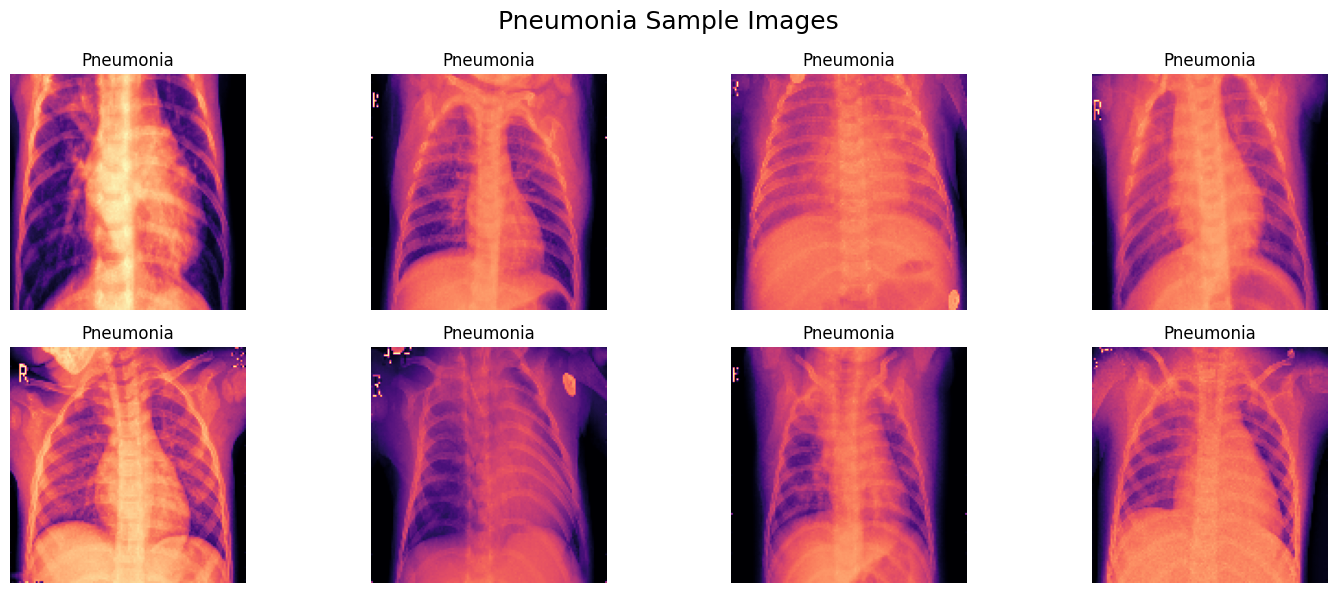

In [3]:
random_indices = np.random.choice(len(train_data), 8, replace=False)
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(train_data[idx], cmap='magma')  
    plt.title('Pneumonia' if train_labels[idx] == 0 else 'Normal')
    plt.axis('off') 

plt.suptitle("Pneumonia Sample Images", size=18)
plt.tight_layout()
plt.show()


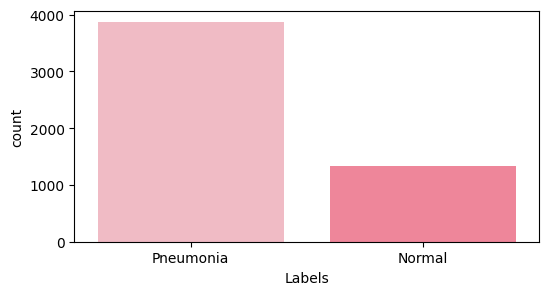

In [4]:
# Training Data Distribution
labels_df = pd.DataFrame({"Labels":train_labels})

plt.figure(figsize=(6,3))
colors = sns.light_palette("#ff758f", n_colors=7)
sns.countplot(data = labels_df, x='Labels', palette=[colors[3], colors[6]])
plt.xticks(ticks=[0, 1], labels=['Pneumonia', 'Normal'])
plt.show()

<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">The training data is imbalanced, with fewer examples for Normal compared to Pneumonia. To address this issue and increase the number of training examples, we will employ data augmentation techniques.</div>

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Data Preprocessing</div>

In [5]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255
X_val = np.array(val_data) / 255

<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">Grayscale normalization is applied to minimize the impact of illumination variations. Also, the CNN converges more quickly on data scaled to the range [0..1] compared to the original range of [0..255].</div>

In [6]:
# resize data for deep learning
img_size= 128

X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(train_labels)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_labels)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(val_labels)

<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">Resizing and reshaping the images ensures they have the same size and format needed for the CNN to work properly. Adding the channel dimension allows the network to handle grayscale images effectively.</div>

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Data Augmentation</div>

In [7]:
# Performing Data Augmentation
data_generator = ImageDataGenerator(  
                    rotation_range = 30,
                    zoom_range = 0.2, 
                    width_shift_range=0.1,  
                    height_shift_range=0.1,  
                    horizontal_flip = True,  
                    shear_range=0.2,
                    fill_mode='nearest',
                 )


data_generator.fit(X_train)

<div style="background-color: #ffccd5; color: #800f2f; padding: 10px; border-radius: 10px;font-family: 'Arial', sans-serif; font-size: 15px; margin: 5px;">Performing data augmentation by applying transformations like rotation, zoom, shifts, and flips. This helps increase the diversity of training data, which improves the model's robustness and generalization by reducing overfitting.</div>

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Training CNN Model</div>

In [8]:
model = Sequential([
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)),

    # Flattening for Dense Layers
    Flatten(),
    
    # Fully connected layer
    Dense(64, activation='relu'), 

    # Output Layer
    Dense(1, activation='sigmoid')
])


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2097152)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   134,217,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,219,137 (512.01 MB)

 Trainable params: 134,219,137 (512.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(data_generator.flow(X_train,y_train, batch_size = 16),
                    epochs = 10 , validation_data = data_generator.flow(X_val, y_val))

Epoch 1/10


I0000 00:00:1725595575.134084     104 service.cc:145] XLA service 0x787a20005ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725595575.134186     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/326 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5491 - loss: 12.1476

I0000 00:00:1725595579.938713     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7596 - loss: 2.0600 - val_accuracy: 0.6250 - val_loss: 1.0676
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8564 - loss: 0.3343 - val_accuracy: 0.8125 - val_loss: 0.8127
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8760 - loss: 0.3104 - val_accuracy: 0.6250 - val_loss: 0.6802
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8850 - loss: 0.2983 - val_accuracy: 0.8750 - val_loss: 0.3958
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8903 - loss: 0.2869 - val_accuracy: 0.6875 - val_loss: 0.6203
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8831 - loss: 0.2821 - val_accuracy: 0.5625 - val_loss: 0.8444
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8987 - loss: 0.2469 - val_accuracy: 0.8125 - val_loss: 0.5725
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8935 - loss: 0.2700 - val_accuracy: 0.68

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Training & Validation Metrics Visualization</div>

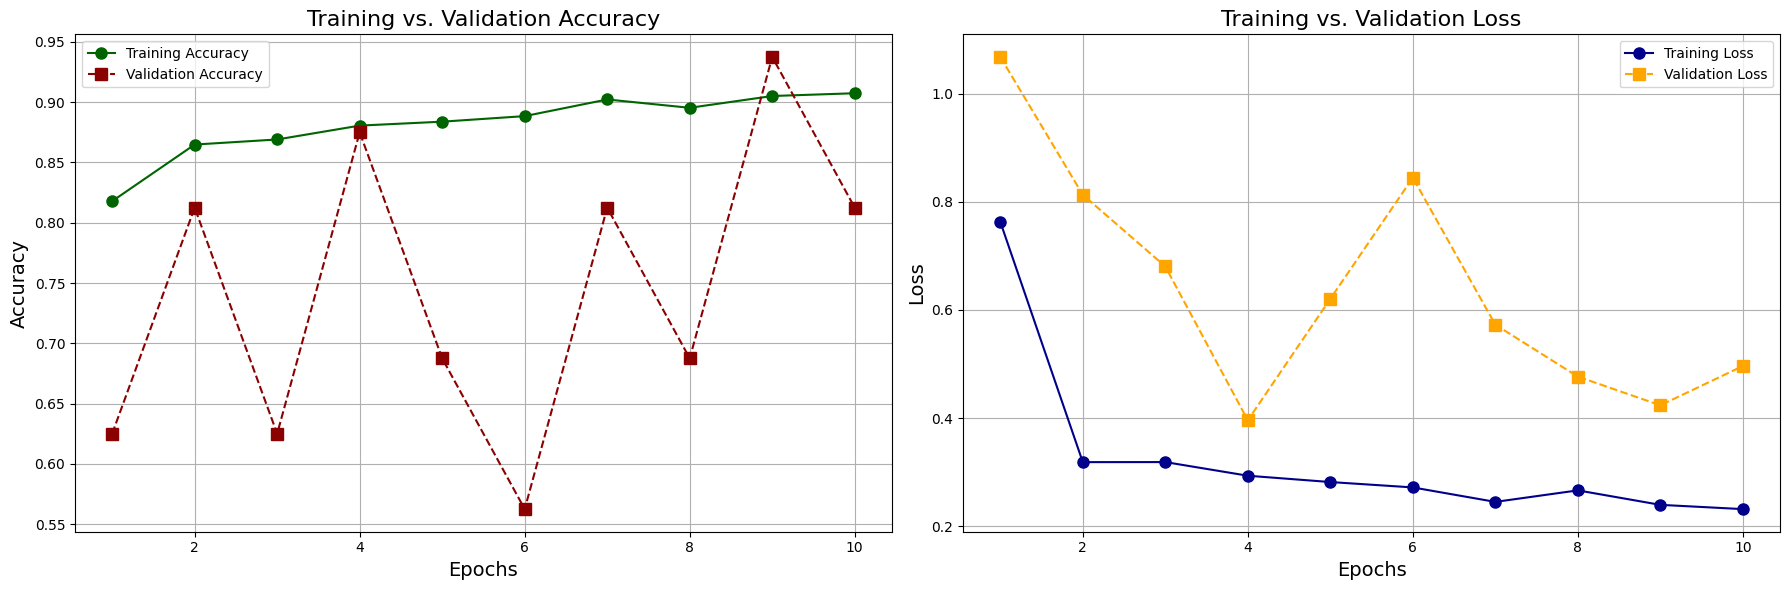

In [10]:
# Retrieve metrics from the training history
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Epochs
epochs = range(1, 11)

# Create a figure and axes for the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation accuracy
ax[0].plot(epochs, train_acc, 'o-', color='darkgreen', label='Training Accuracy', markersize=8)
ax[0].plot(epochs, val_acc, 's--', color='darkred', label='Validation Accuracy', markersize=8)
ax[0].set_title('Training vs. Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend()
ax[0].grid(True)

# Plot training and validation loss
ax[1].plot(epochs, train_loss, 'o-', color='darkblue', label='Training Loss', markersize=8)
ax[1].plot(epochs, val_loss, 's--', color='orange', label='Validation Loss', markersize=8)
ax[1].set_title('Training vs. Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].legend()
ax[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

# <div style="background-color: #ff758f; color: white; padding: 10px; border-radius: 10px;text-align: center;font-family: 'Arial', sans-serif; font-size: 30px; margin: 5px; font-weight:bold;">Model Performance on Testing Data</div>

In [11]:
evaluation = model.evaluate(X_test,y_test)
print("=="*20)
print(f"Accuracy - {evaluation[1]*100}%")
print(f"Loss - {evaluation[0]}")
print("=="*20)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8700 - loss: 0.2662
Accuracy - 83.49359035491943%
Loss - 0.4113359749317169


In [12]:
# Predicting on Test data
predictions = model.predict(X_test)
predictions = predictions.reshape(1,-1)[0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


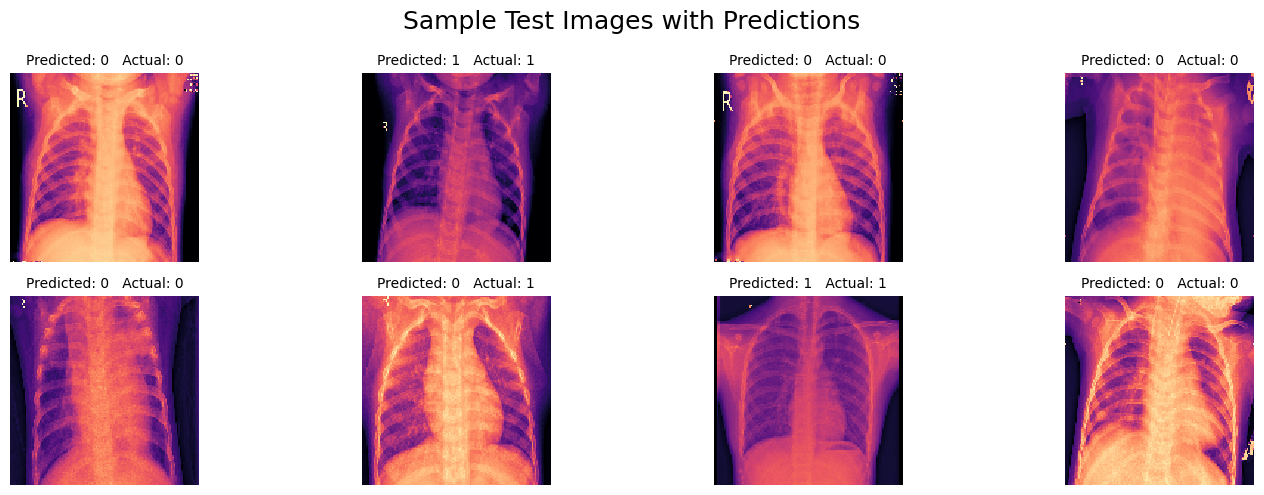

In [15]:
# Randomly select 8 indices from the test set
random_indices = np.random.choice(len(X_test), 8, replace=False)

# Define the figure size
plt.figure(figsize=(15, 5))

# Iterate through the selected indices
for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    
    # Display the image
    plt.imshow(X_test[idx].reshape(128, 128), cmap='magma', interpolation='none')
    
    # Set the title with predicted and actual classes
    plt.title(f"Predicted: {round(predictions[idx])}   Actual: {y_test[idx]}", fontsize=10)
    
    # Remove x and y ticks
    plt.axis('off')

# Set the main title for the figure
plt.suptitle("Sample Test Images with Predictions", size=18)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()